In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import numpy as np # linear algebra
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
img = []
data = []
lbl = []
rot = []

In [ ]:
for dirname, _, filenames in os.walk('kaggle_data2/dataset4_csv'):
    for filename in filenames:
        rows = open(os.path.join('kaggle_data2/dataset4_csv',filename)).read().strip().split('\n')
        for row in rows:
            row = row.split(',')
            (x,y,label,rotation,pathimg) = row
            image = load_img(os.path.join('kaggle_data2',pathimg), target_size=(256, 256))
            image = img_to_array(image)
            img.append(image)
            data.append([x,y])
            lbl.append(label)
            rot.append(rotation)

In [ ]:
img = np.array(img,dtype='float32')
data = np.array(data,dtype='float32')
lbl = np.array(lbl)
rot = np.array(rot)

In [ ]:
lb = LabelBinarizer()
lbl = lb.fit_transform(lbl)
rot = lb.fit_transform(rot)

In [ ]:
split = train_test_split(img, lbl, rot, data, test_size=0.1)
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainRotations, testRotations) = split[4:6]
(trainCoordinates, testCoordinates) = split[6:8]

In [ ]:
split = train_test_split(trainImages, trainLabels, trainRotations, trainCoordinates, test_size=0.1)
(trainImages, valImages) = split[:2]
(trainLabels, valLabels) = split[2:4]
(trainRotations, valRotations) = split[4:6]
(trainCoordinates, valCoordinates) = split[6:8]

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input, Rescaling

In [ ]:
#input layer
inputs = Input(shape=(256,256,3))
scaled_inputs = Rescaling(1/255)(inputs)

In [ ]:
#cnn branch
c = Conv2D(16, (3,3), 1, activation = 'relu')(scaled_inputs)
c = MaxPooling2D()(c)
c = Conv2D(32, (3,3), 1, activation = 'relu')(c)
c = MaxPooling2D()(c)
c = Conv2D(16, (3,3), 1, activation = 'relu')(c)
c = MaxPooling2D()(c)
c = Flatten()(c)
c = Dense(256, activation = 'relu')(c)
l = Dense(3, activation = 'softmax', name='label')(c)

In [ ]:
#rot branch
r = Dense(15, activation = 'softmax', name='rotation')(c)

In [ ]:
#ann branch
a = Conv2D(16, (3,3), 1, activation = 'relu')(scaled_inputs)
a = MaxPooling2D()(a)
a = Conv2D(32, (3,3), 1, activation = 'relu')(a)
a = MaxPooling2D()(a)
a = Conv2D(64, (3,3), 1, activation = 'relu')(a)
a = MaxPooling2D()(a)
a = Conv2D(128, (3,3), 1, activation = 'relu')(a)
a = MaxPooling2D()(a)
a = Flatten()(a)
a = Dense(32, activation = 'linear')(a)
a = Dense(32, activation = 'linear', kernel_regularizer='l2', bias_regularizer='l2')(a)
a = Dense(32, activation = 'linear', kernel_regularizer='l2', bias_regularizer='l2')(a)
a = Dense(32, activation = 'linear')(a)
a = Dense(2, activation = 'linear', name='ann')(a)

In [ ]:
#model
model = Model(
	inputs=inputs,
	outputs=(l, r, a))

In [ ]:
#compile
model.compile(loss={
	'label': 'categorical_crossentropy',
	'rotation': 'categorical_crossentropy',
	'coordinate': 'mse',
}, optimizer='adam', metrics=['accuracy'])

In [ ]:
hist = model.fit(
	trainImages, {
	'label': trainLabels,
	'rotation': trainRotations,
	'coordinate': trainCoordinates,
},
	validation_data= (valImages, {
	'label': valLabels,
	'rotation': valRotations,
	'coordinate': valCoordinates,
}),
	batch_size=32,
	epochs=20)

In [1]:
import numpy as np
import cv2
from keras.models import load_model
from matplotlib import pyplot as plt

In [2]:
image = cv2.imread('96trans50_-150.jpg')
image_show = np.array(image, dtype='float32')
height, width = image_show.shape[:2]
image_input = cv2.resize(image_show, (256,256))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


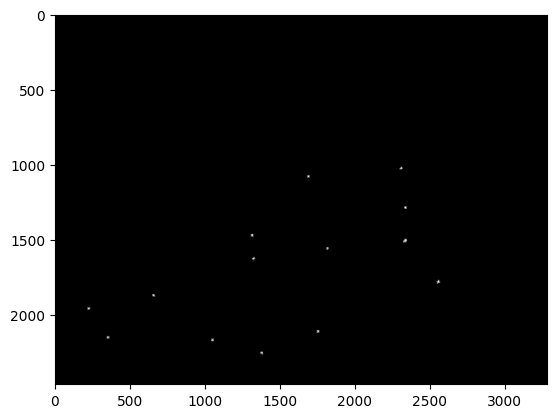

In [3]:
plt.imshow(image_show)

In [4]:
model = load_model('super1.h5', compile=False)
model.compile(loss={
	'label': 'categorical_crossentropy',
	'rotation': 'categorical_crossentropy',
	'coordinate': 'mse',
}, optimizer='adam', metrics=['accuracy'])

In [5]:
y = model.predict(np.expand_dims(image_input,0))

In [6]:
labels = ['ID_1', 'ID_2', 'ID_3']
rotations = [0,120,144,168,192,216,24,240,264,288,312,336,48,72,96]

In [7]:
label = y[0].argmax()
rotation = y[1].argmax()
co_x = y[2][0][0]
co_y = y[2][0][1]

In [8]:
cv2.circle(image_show, (int(np.around(co_x*width+width/2)),int(np.around(co_y*height+height/2))), 190, (255,255,255), thickness=2)
cv2.putText(image_show, str(labels[label]) + ' ' + str(rotations[rotation]) + ' degree', (100,100), cv2.FONT_HERSHEY_TRIPLEX, 4, (255,255,255), thickness=2)

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


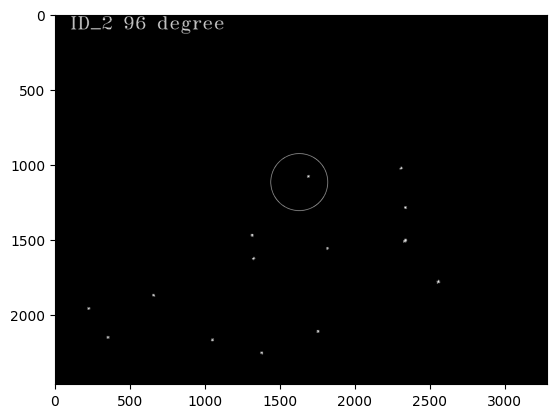

In [9]:
plt.imshow(image_show)